In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [2]:
# set graphical parameters
% matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 90
sns.set_context('notebook', font_scale=1.05)
sns.set_style('white')

pal = ['#066b2b', '#0a3e78', '#ae1626','#444745','#55a15a', '#5588a1', 'indianred']

In [3]:
wd = 'data\\' #path if you download the data folder and save in the same location with the notebook

#wd = 'C:\\Users\\Aaron\\Dropbox\\MSPA\\Pred498\\Group Project\\'

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

train = pd.read_csv(wd + 'train.csv', parse_dates=[2], date_parser=dateparse, index_col='Date')
store = pd.read_csv(wd + 'store.csv')

C:\Users\ponle\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['Sales_Per_Customer'] = train['Sales'] / train['Customers']

In [5]:
train.index # in reverse order (newest data points first)

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [6]:
train.shape

(1017209, 13)

Join Train and Store data:

In [7]:
train_idx = train.reset_index()

merged_data = pd.merge(train_idx, store, how = 'inner', on = 'Store')
merged_data.index = merged_data.Date
merged_data = merged_data.iloc[:,1:]

## Data Quality
Quick look at the quality of the data to identify missing values or any other issues which need to be cleaned prior to modeling. 

In [8]:
# any missing values?
train.isnull().sum()

Store                      0
DayOfWeek                  0
Sales                      0
Customers                  0
Open                       0
Promo                      0
StateHoliday               0
SchoolHoliday              0
Year                       0
Month                      0
Day                        0
WeekOfYear                 0
Sales_Per_Customer    172869
dtype: int64

In [9]:
len(train[train['Sales'] == 0])

172871

In [10]:
pd.concat([train['Open'].value_counts(),
           train['Open'].value_counts(normalize = True)], 
          axis = 1)

,Open,Open
1,844392,0.830107
0,172817,0.169893


In [11]:
len(train[(train.Open == 1) & (train.Sales == 0)])

54

For nearly 17% of the data in the training set, the stores are closed and sales are equal to 0. We don't need to generate forecasts for these days since they should always be 0.

Which days are stores closed? The majority of closures are on the 7th day of the week (sunday?). Are these particular stores?

In [12]:
train[train['Open'] == 0]['DayOfWeek'].value_counts()

7    141137
4     11201
5      7205
1      7170
3      3729
2      1703
6       672
Name: DayOfWeek, dtype: int64

In [13]:
train[train['Open'] == 0].groupby(['StateHoliday', 'SchoolHoliday'])['Open'].aggregate('count').unstack()

SchoolHoliday,0,1
StateHoliday,,
0,18128.0,804.0
0,121482.0,2263.0
a,14465.0,5101.0
b,478.0,6067.0
c,NaN,4029.0


In [15]:
merged_data.groupby(['StoreType', 'DayOfWeek'])['Open'].value_counts().unstack()

Open                       0        1
StoreType DayOfWeek                  
a         1           3881.0  74603.0
          2            890.0  78111.0
          3           2009.0  76993.0
          4           6060.0  73026.0
          5           3956.0  75130.0
          6            370.0  78114.0
          7          77384.0   1100.0
b         1             37.0   2215.0
          2             40.0   2228.0
          3             40.0   2228.0
          4             39.0   2230.0
          5             38.0   2231.0
          6             37.0   2215.0
          7             36.0   2216.0
c         1           1010.0  18458.0
          2            259.0  19343.0
          3            549.0  19053.0
          4           1473.0  18143.0
          5           1003.0  18613.0
          6            100.0  19368.0
          7          19468.0      NaN
d         1           2242.0  42284.0
          2            514.0  44279.0
          3           1131.0  43662.0
          4           3629.0  41245.0
          5           2208.0  42666.0
          6            165.0  44361.0
          7          44249.0    277.0


A few things:

* There aren't any missing values in the dataset, overall the data quality appears to be good.
* While there aren't missing values, there are 172,871 instances where Sales = 0 (~17% of dataset).
* Most of the time this makes sense (i.e. the store is closed, which often happens on Sundays or it's a holiday. <u> Note: store type C is always closed on Sundays and D is usually closed on Sundays.</u>
* There are 54 instances when a store was open and 0 sales were recorded.
* Suggestion: we won't need to forecast the sales when a store is closed (this is guaranteed to be 0). We can exclude these from the forecasting model.

## Analysis of Sales (Target Variable)

* How do sales vary (what does the distribution of sales look like and how is it impacted by the various explanatory features?)

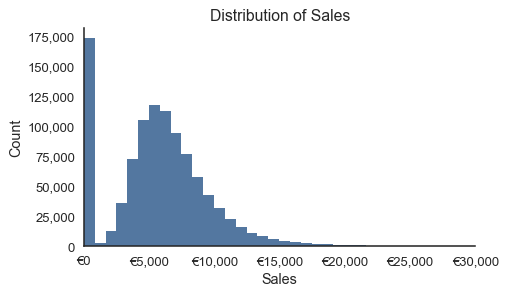

In [16]:
fig, ax = plt.subplots(figsize = (5, 3))

ax.hist(train['Sales'], alpha = .7, bins=50, color = pal[1])
ax.set_title('Distribution of Sales')
ax.set_ylabel('Count', fontname = 'Arial')
ax.set_xlabel('Sales', fontname = 'Arial')
ax.set_xlim(0, 30000)

x_vals = ax.get_xticks()
ax.set_xticklabels(['€{:,.0f}'.format(x) for x in x_vals], fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

### Sales by Store, Customer

In [17]:
train['Sales_Per_Customer'] = train['Sales'] / train['Customers']
train['Sales_Per_Customer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: Sales_Per_Customer, dtype: float64

The mean sales per customer is ~$9.50

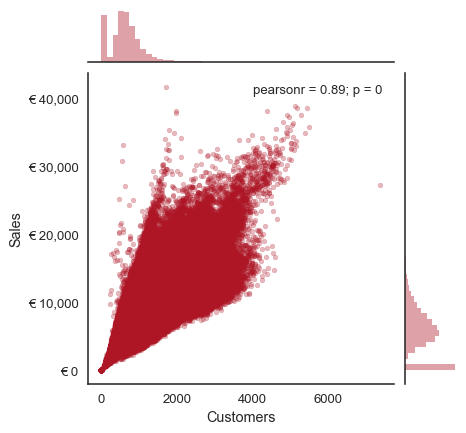

In [18]:
g = sns.jointplot(x = 'Customers', y = 'Sales', data = train, color = pal[2], alpha = 0.3, joint_kws={'s': 15}, size = 5)
y_vals = g.ax_joint.get_yticks()
g.ax_joint.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals]);


* Check the variability around customers, sales per customer at the store level.

### Overall Sales - Downsampling

Group by date and analyze total sales over time

In [19]:
train_grp = pd.DataFrame(train.groupby('Date')['Sales', 'Customers'].sum())
train_ds = pd.DataFrame(train_grp.resample('W').sum())
train_ds['SalesPerCustomer'] = train_ds.Sales / train_ds.Customers
train_ds['Sales_4RA'] = pd.rolling_mean(train_ds.Sales, window = 4, center=True)
train_ds['Customers_4RA'] = pd.rolling_mean(train_ds.Customers, window = 4, center = True)
train_ds['SpC_4RA'] = pd.rolling_mean(train_ds.SalesPerCustomer, window = 4, center = True)
train_ds.head()

C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()
  after removing the cwd from sys.path.
C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()
  """
C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()
  


,Sales,Customers,SalesPerCustomer,Sales_4RA,Customers_4RA,SpC_4RA
Date,,,,,,
2013-01-06,26129335,3110602,8.400089,NaN,NaN,NaN
2013-01-13,49275222,5226350,9.428228,NaN,NaN,NaN
2013-01-20,34377765,4205743,8.174005,38955622.75,4367882.00,8.835828
2013-01-27,46040169,4928833,9.340988,42039796.25,4717144.00,8.869180
2013-02-03,38466029,4507650,8.533499,41971561.50,4717216.25,8.855995


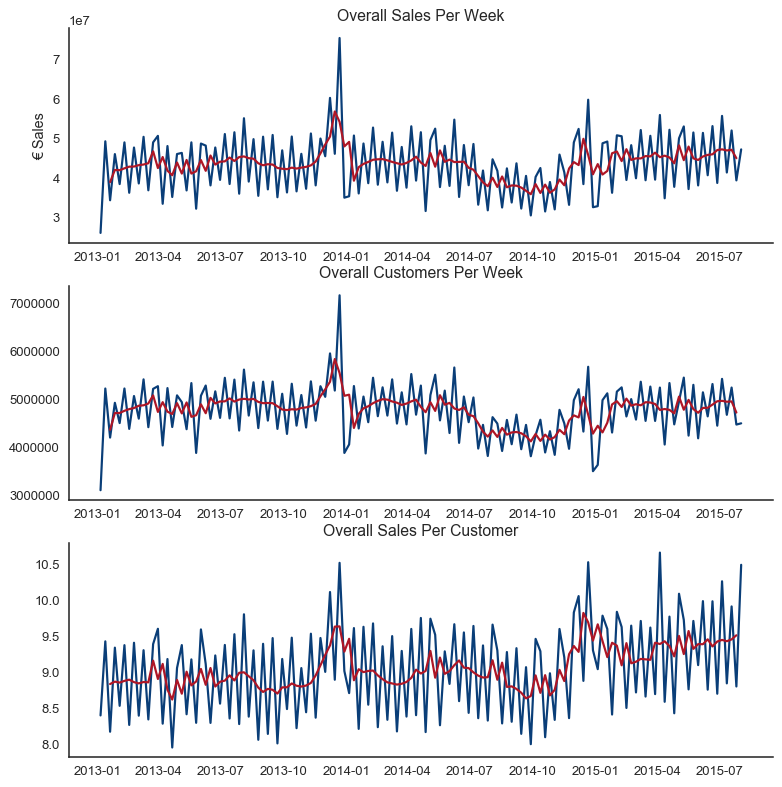

In [20]:
fig, ax = plt.subplots(3, 1, figsize = (9, 10))
ax11, ax21, ax31 = ax.ravel()

ax11.plot(train_ds['Sales'], color = pal[1])
ax11.plot(train_ds['Sales_4RA'], color = pal[2])
ax11.set_title('Overall Sales Per Week' ,fontname = 'Arial')
ax11.set_ylabel('€ Sales', fontname = 'Arial')

ax21.plot(train_ds['Customers'], color = pal[1])
ax21.plot(train_ds['Customers_4RA'], color = pal[2])
ax21.set_title('Overall Customers Per Week')


ax31.plot(train_ds['SalesPerCustomer'], color = pal[1])
ax31.plot(train_ds['SpC_4RA'], color = pal[2])
ax31.set_title('Overall Sales Per Customer')
sns.despine();


## Store Types

Let's look at the store types to understand their sales, customer volumes, and sales per customer.

#### Sales by Store Type

In [21]:
merged_data.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


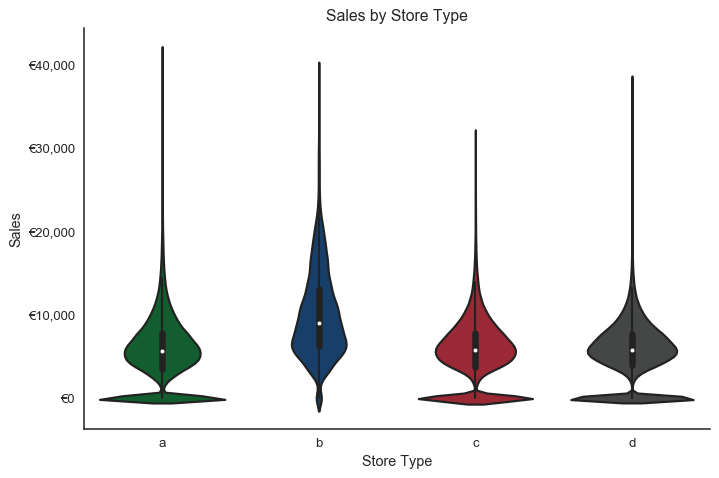

In [22]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StoreType', y = 'Sales',order= ["a","b","c","d"], data = merged_data,palette = pal)
ax.set_title('Sales by Store Type')
ax.set_xlabel('Store Type')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [23]:
print("Median Sales by store type")
merged_data.groupby("StoreType")["Sales"].median()

Median Sales by store type


StoreType
a    5618.0
b    9025.5
c    5766.0
d    5826.0
Name: Sales, dtype: float64

#### Customer Volume and Store Type

In [24]:
merged_data.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,659.034880,462.930320,0.0,414.0,647.0,890.0,7388.0
b,15830.0,1987.720846,940.088627,0.0,1228.0,1820.0,2732.0,5494.0
c,136840.0,673.265894,430.708776,0.0,455.0,682.0,924.0,3096.0
d,312912.0,501.434892,292.301770,0.0,375.0,530.0,681.0,2239.0


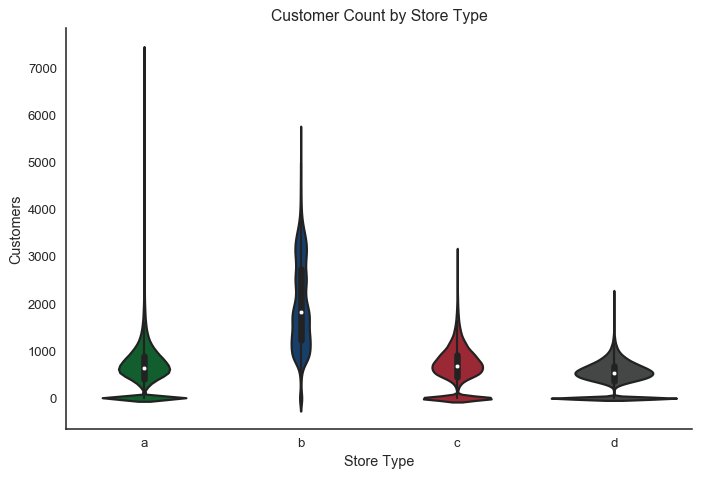

In [25]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StoreType', y = 'Customers',order= ["a","b","c","d"], data = merged_data,palette = pal)
ax.set_title('Customer Count by Store Type')
ax.set_xlabel('Store Type')
ax.set_ylabel('Customers')

y_vals = ax.get_yticks()
#ax.set_yticklabels(['${:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [26]:
print("Median Customers by store type")
merged_data.groupby("StoreType")["Customers"].median()

Median Customers by store type


StoreType
a     647
b    1820
c     682
d     530
Name: Customers, dtype: int64

#### Sales Per Customer by Store Type

In [27]:
merged_data.groupby('StoreType')['Sales_Per_Customer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457043.0,8.846277,1.690962,0.000000,7.611940,8.631362,9.899435,29.877551
b,15561.0,5.133097,1.254623,0.000000,4.039384,4.986865,6.108364,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


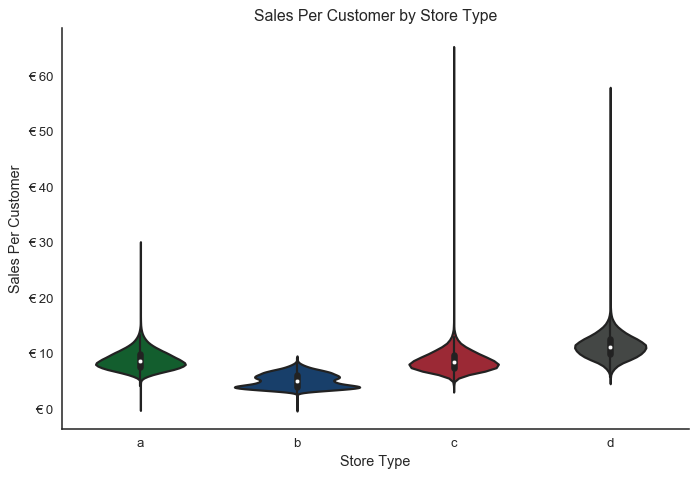

In [28]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StoreType', 
                    y = 'Sales_Per_Customer',
                    order= ["a","b","c","d"], 
                    data = merged_data,
                    palette = pal)

ax.set_title('Sales Per Customer by Store Type')
ax.set_xlabel('Store Type')
ax.set_ylabel('Sales Per Customer')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [29]:
print("Median Sales per Customer by store type")
merged_data.groupby("StoreType")["Sales_Per_Customer"].median()

Median Sales per Customer by store type


StoreType
a     8.631362
b     4.986865
c     8.424736
d    11.194977
Name: Sales_Per_Customer, dtype: float64

* Store type 'b' has the highest overall average sales along with the highest variation, which appears to be driven by the wide variability in number of customers for this store type. Interestingly, 'b' has the lowest average sale per customer. Thus, this store generally has higher volume of customers but customers tend to spend quite a bit less (shopping for either smaller/cheaper or fewer items).
* Stores types a, c, and d have very similar average sale amounts (per day), though store type 'd', on average, has at least 100 fewer customers per day. Store type 'd' has the highest sale per customer at $11.19, it also has the highest variation in sales per customer.
* Store type 'a' has the widest variation in customer volume, though its average is in line with the other store types, there may be individual stores with high customer volume or store A may be the most impacted by promotions, holidays, etc. (verify?)

## Promotions

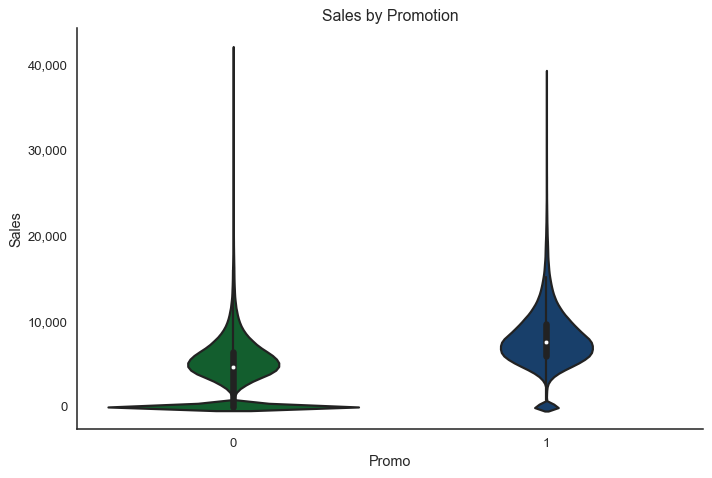

In [30]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'Promo', y = 'Sales', data = train, palette = pal)
ax.set_title('Sales by Promotion')
ax.set_xlabel('Promo')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

How does sales per customer change during promotional periods?

In [31]:
train.groupby('Promo')['Sales_Per_Customer'].median()

Promo
0    8.741597
1    9.956947
Name: Sales_Per_Customer, dtype: float64

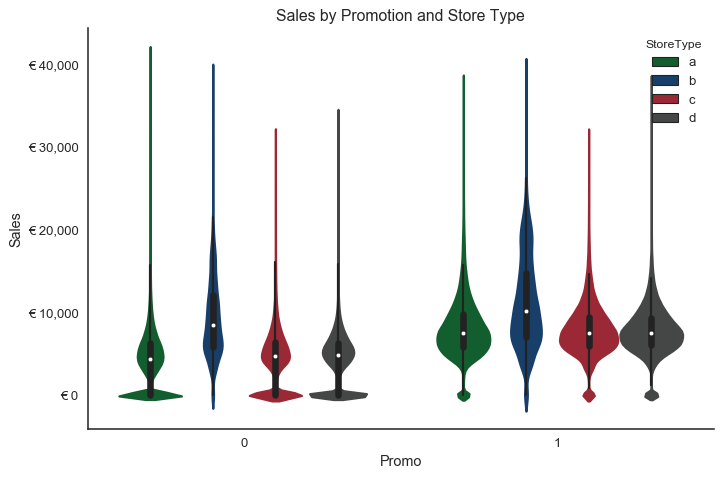

In [32]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'Promo', 
                    y = 'Sales', 
                    hue = 'StoreType',
                    data = merged_data,
                    hue_order = ['a', 'b','c', 'd'],
                    palette = pal)

ax.set_title('Sales by Promotion and Store Type')
ax.set_xlabel('Promo')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [33]:
merged_data.groupby(['Promo', 'StoreType'])['Sales'].median().unstack()

StoreType,a,b,c,d
Promo,,,,
0,4408.0,8417.5,4661.0,4815.0
1,7544.0,10099.0,7479.0,7536.0


Sales increase across the board for each store type during promotions.

#### Sales Per Customer during Promotions

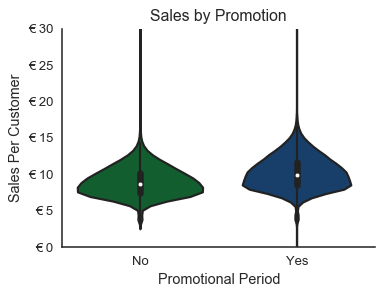

In [34]:
fig, ax = plt.subplots(figsize = (4, 3))
ax = sns.violinplot(x = 'Promo', y = 'Sales_Per_Customer', data = train, palette=pal, alpha = 0.8)
ax.set_title('Sales by Promotion', fontname = 'Arial')
ax.set_xlabel('Promotional Period', fontname = 'Arial')
ax.set_ylabel('Sales Per Customer', fontname = 'Arial')

ax.set_ylim(0, 30)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

x_vals = ax.get_xticks()
ax.set_xticklabels(['No', 'Yes'], fontname = 'Arial')

sns.despine();

### Impact of Promotions, Holidays on Sales

In [35]:
train.groupby('Promo')['Sales_Per_Customer'].median()

Promo
0    8.741597
1    9.956947
Name: Sales_Per_Customer, dtype: float64

As expected, generally higher sales during promotional periods.

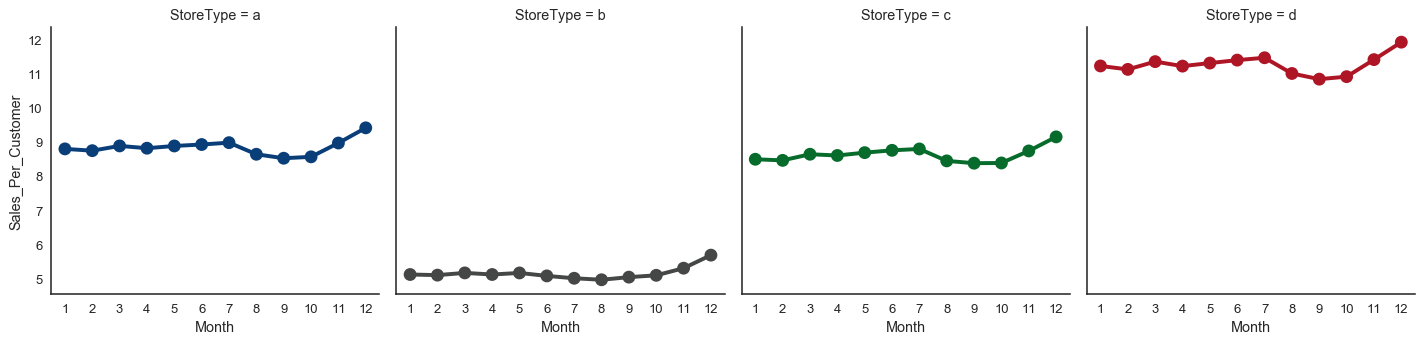

In [36]:
sns.factorplot(data = merged_data, 
               x = 'Month', 
               y = "Sales_Per_Customer", 
               col = 'StoreType', 
               palette = pal,
               hue = 'StoreType',
              col_order = ['a', 'b', 'c', 'd']);

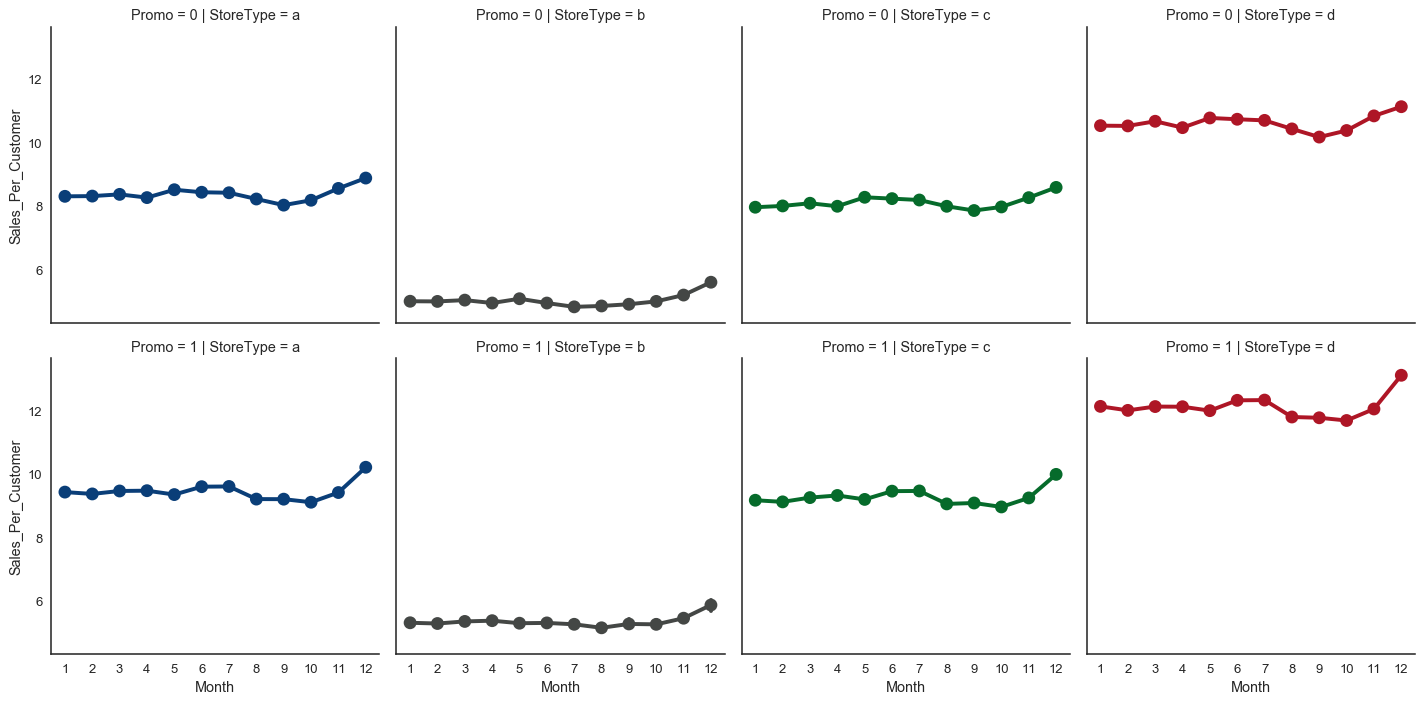

In [37]:
sns.factorplot(data = merged_data,
               x = 'Month', 
               y = "Sales_Per_Customer", 
               col = 'StoreType', 
               hue = 'StoreType',
               row = 'Promo',
              palette = pal,
              col_order = ['a', 'b', 'c', 'd']); 

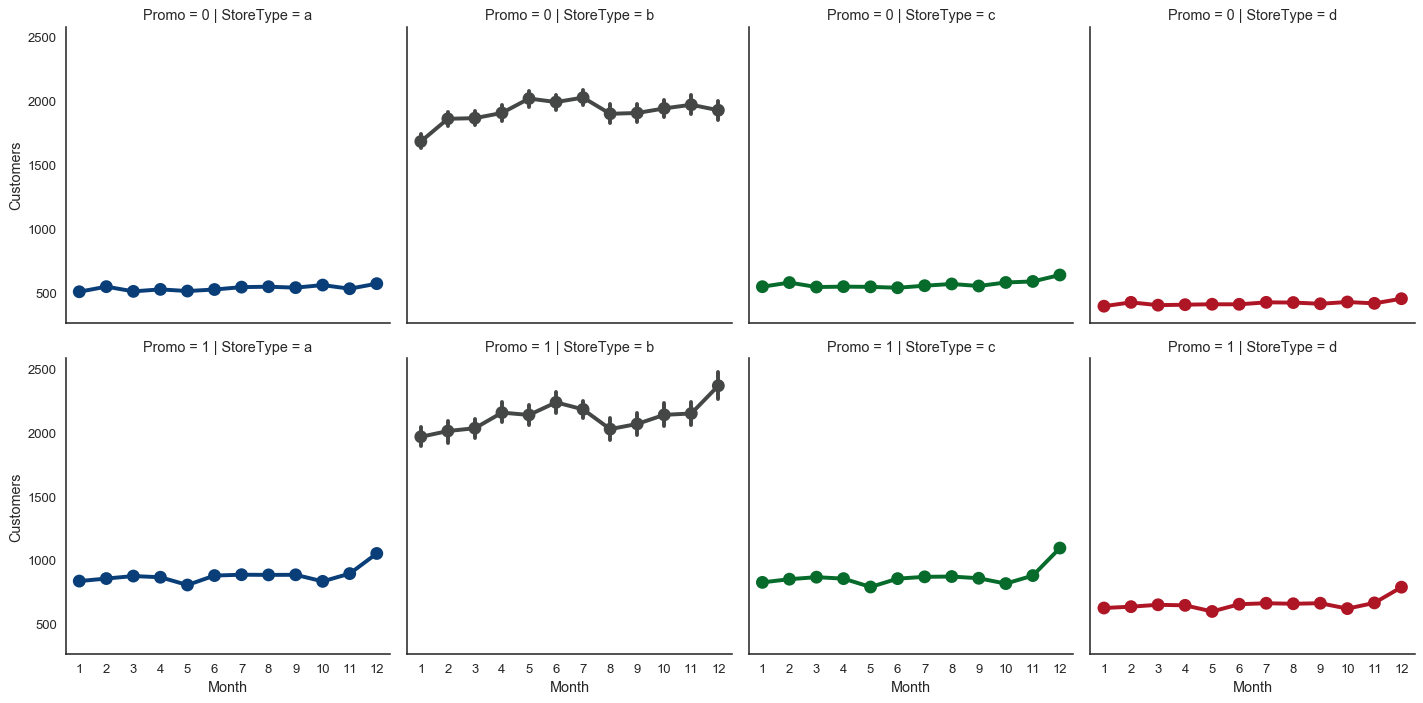

In [38]:
sns.factorplot(data = merged_data,
               x = 'Month', 
               y = "Customers", 
               col = 'StoreType', 
               hue = 'StoreType',
               row = 'Promo',
              palette = pal,
              col_order = ['a', 'b', 'c', 'd']); 

####  Impact of Promo2 on Sales
Promo (graphs above) indicates whether the store is running a promotion for just that day. Promo2 is a continuing and consecutive promotion. 

We cannot just use whether the store is participating, we need to identify when the store began Promo2 and the Promotional intervals (the months the promotion is started anew)

In [39]:
from datetime import datetime

def get_date_(year, week):
    if (np.isnan(year)) or (np.isnan(week)):
        return(np.nan)
    else:
        
        date_ = '{} {}'.format(np.int(year), np.int(week))
        date_out = datetime.strptime(date_ + ' 0', '%Y %W %w')
        return(date_out)


merged_data['Promo2_Start_Date'] = merged_data.apply(lambda row:\
                                                    get_date_(row['Promo2SinceYear'],
                                                             row['Promo2SinceWeek']), axis = 1)

merged_data['Days_Promo2_Participating'] = (merged_data.index - merged_data.Promo2_Start_Date)
merged_data['Days_Promo2_Participating'] = merged_data.Days_Promo2_Participating.dt.days

promo2 = merged_data[(merged_data['Promo2'] == 1) & merged_data['Open'] == 1]
promo2 = promo2[(promo2['Days_Promo2_Participating'] >= -60) & \
               (promo2['Days_Promo2_Participating'] <= 360)]

From 2 months before to 12 months after beginning participation in Promo2, what is the average impact on sales? Based on the graph below, on average there appears to be an increase in sales, reaching a maximum point shortly after 200 days and then sales begin to decline

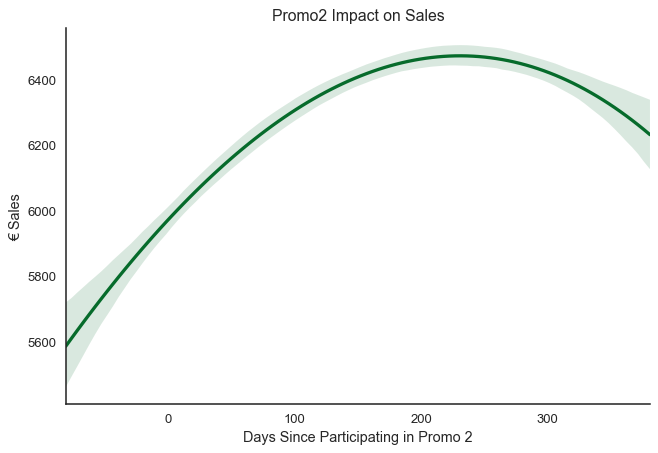

In [40]:
g = sns.lmplot(x = 'Days_Promo2_Participating',
              y = 'Sales',
              data = promo2,
              order = 3, 
              size = 5,
              aspect = 1.5, 
              scatter = False,
              line_kws={'color': pal[0]})

plt.xlabel('Days Since Participating in Promo 2')
plt.ylabel('€ Sales')
plt.title('Promo2 Impact on Sales');

In [41]:
promo2['Days_Cut'] = pd.qcut(promo2.Days_Promo2_Participating, 10)
promo2.groupby('Days_Cut')['Sales'].median()

Days_Cut
(-60.001, -2.0]    5302.0
(-2.0, 50.0]       5419.0
(50.0, 97.0]       5726.0
(97.0, 136.0]      5888.0
(136.0, 174.0]     5976.0
(174.0, 212.0]     5856.0
(212.0, 247.0]     5824.0
(247.0, 281.0]     6067.0
(281.0, 319.0]     5841.5
(319.0, 360.0]     5885.0
Name: Sales, dtype: float64

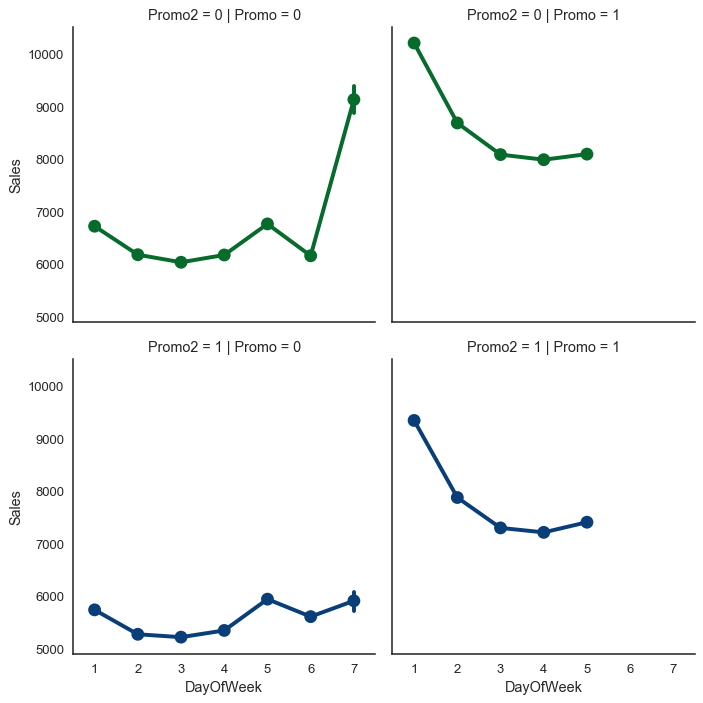

In [42]:
g = sns.factorplot(data = merged_data[merged_data['Open'] == 1],
              x = 'DayOfWeek',
              y = 'Sales',
              col = 'Promo',
              row = 'Promo2',
              hue = 'Promo2',
              palette = pal);

In [43]:
merged_data[merged_data['Open'] == 1].groupby('DayOfWeek')['Promo'].sum()

DayOfWeek
1    77243
2    77118
3    76257
4    74123
5    72155
6        0
7        0
Name: Promo, dtype: int64

Points on Promotions:
* Daily promotions appear to have an impact on each store type, increasing average sales per customer by several dollars. This is driven by both an increase in customer volume and an increase in sales per customer. 
* When a store begins participating in Promo2, their sales on average do increase (hitting a max somewhere around 9 months). 
* A store which is not running a promotion appears to have highest sales on Sundays, whereas stores running promotions (promo not promo2) appear to have highest sales earlier in the week (due to the fact that more promotions are run on these days - there aren't any promotions run on the weekends). Promo2 doesn't appear to have impacts on the day of week sales, though does appear to impact sales in the long run when a store is participating.


## Day of Week and Holidays

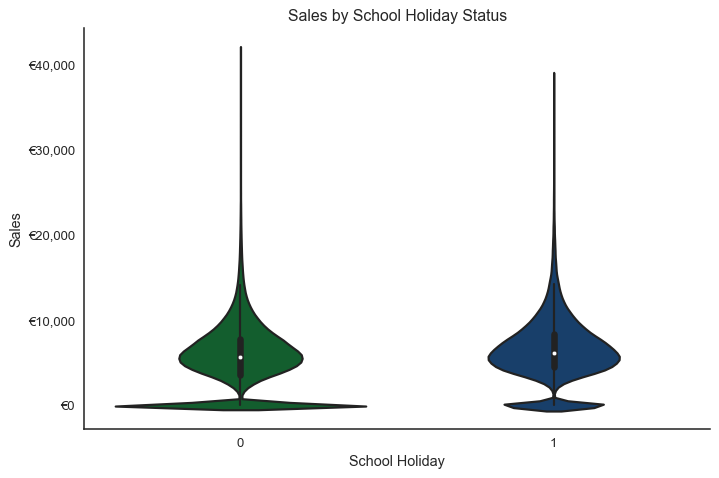

In [44]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'SchoolHoliday', y = 'Sales', data = train, palette = pal)
ax.set_title('Sales by School Holiday Status')
ax.set_xlabel('School Holiday')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [45]:
train['StateHoliday'].value_counts().index

Index(['0', 0, 'a', 'b', 'c'], dtype='object')

In [46]:
# fix zeros on StateHoliday
def zero_str(var):
    if var == 0:
        return('0')
    else:
        return(var)
    
train['StateHoliday'] = train['StateHoliday'].apply(lambda x: zero_str(x))
merged_data['StateHoliday'] = merged_data['StateHoliday'].apply(lambda x: zero_str(x))

train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

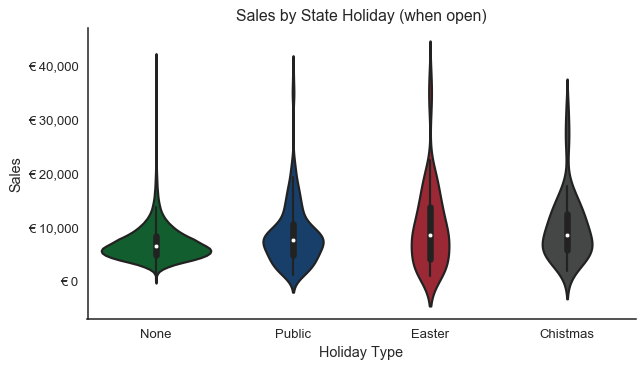

In [47]:
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales', data = train[train['Open']==1], palette = pal)
ax.set_title('Sales by State Holiday (when open)', fontname = 'Arial')
ax.set_xlabel('Holiday Type', fontname = 'Arial')
ax.set_ylabel('Sales', fontname = 'Arial')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list, fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

sns.despine();

In [48]:
train[train['Open'] == 1].groupby('StateHoliday')['Sales'].median()

StateHoliday
0    6368
a    7556
b    8423
c    8397
Name: Sales, dtype: int64

##### Do people spend more on holidays?

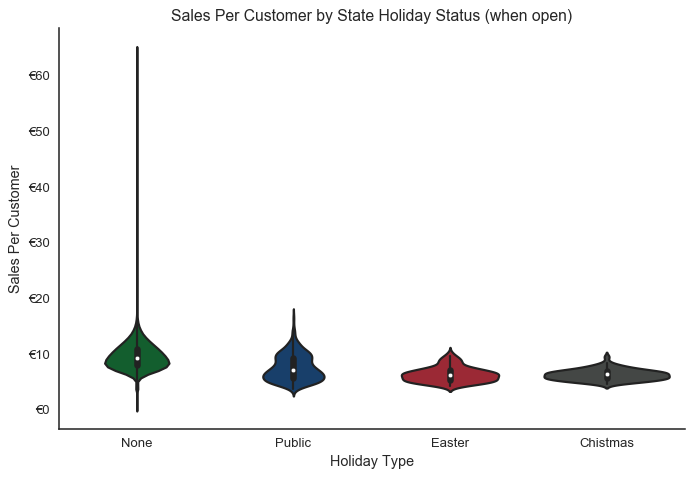

In [49]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales_Per_Customer', data = train[train['Open']==1],
                   palette = pal)
ax.set_title('Sales Per Customer by State Holiday Status (when open)')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Sales Per Customer')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

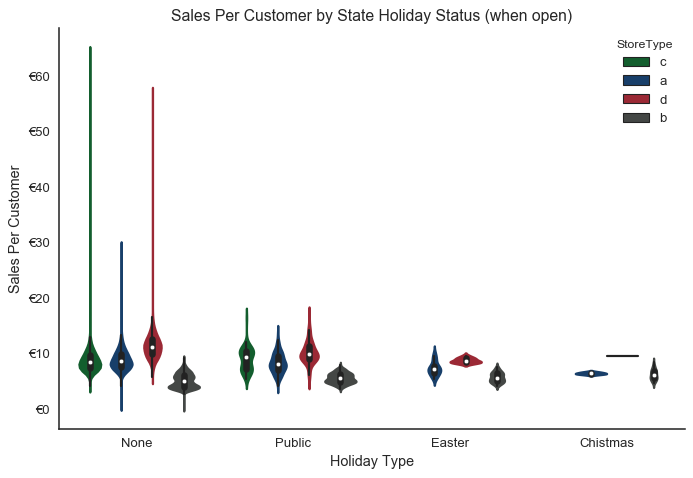

In [50]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales_Per_Customer',
                    hue = 'StoreType', data = merged_data[merged_data['Open']==1],
                   palette = pal)
ax.set_title('Sales Per Customer by State Holiday Status (when open)')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Sales Per Customer')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

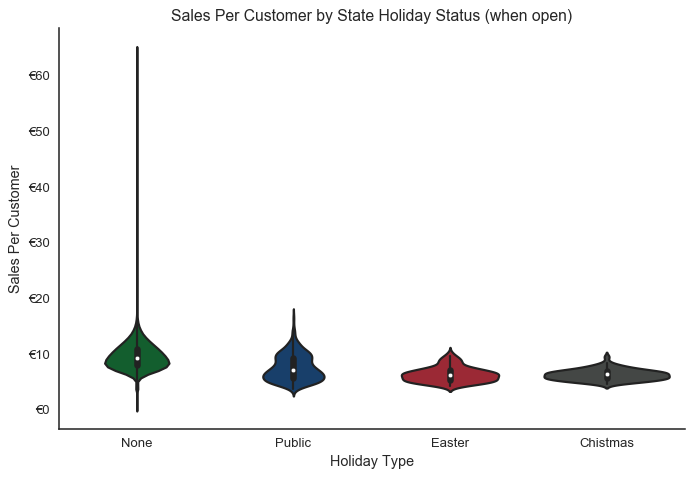

In [51]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales_Per_Customer', data = train[train['Open']==1],
                   palette = pal)
ax.set_title('Sales Per Customer by State Holiday Status (when open)')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Sales Per Customer')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

### Sales by Date of Week

In [52]:
train[train['Open']==1].groupby('DayOfWeek')['Sales'].median()

DayOfWeek
1    7539
2    6502
3    6210
4    6246
5    6580
6    5425
7    6876
Name: Sales, dtype: int64

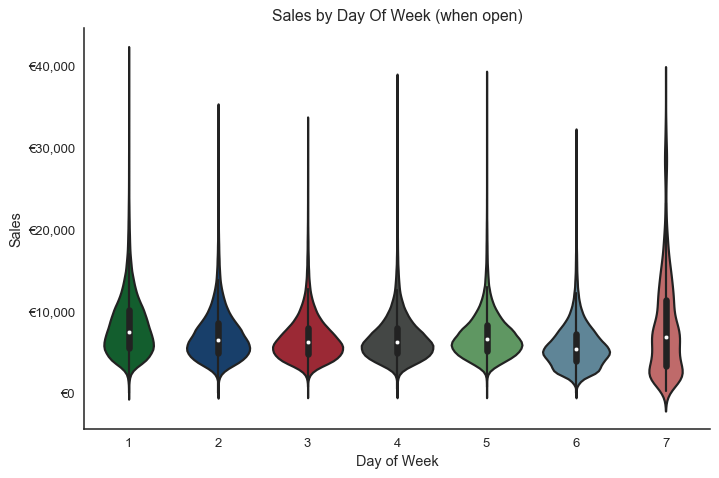

In [53]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'DayOfWeek', y = 'Sales', data = train[train['Open']==1], palette = pal)
ax.set_title('Sales by Day Of Week (when open)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])
sns.despine();

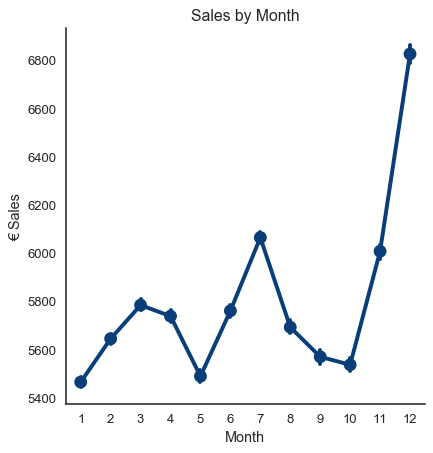

In [54]:
g = sns.factorplot( x = 'Month',
                y = 'Sales',
                data = merged_data,
                size = 5,
                color=pal[1]
                  )

g.set_xlabels('Month')
g.set_ylabels('€ Sales')
plt.title('Sales by Month')
# y_vals = g.ax_factor.get_yticks()
# g.ax_factor.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])
sns.despine();

Day of Week, Month, Holiday Summary:

* Sales tend to peak during the summer months and around Christmas (though this varies by store type)
* Day of Week and Holiday status aren't very informative by themselves: they become more informative when taking into account store type
* Interestingly, the variability in sales per customer decreases (without an overall increase in sales) during state holidays - even within store types

## Competitors

In [55]:
def competition(var):
    if var > 0:
        return(1)
    else:
        return(0)
    
merged_data['Ind_Competition'] = merged_data['CompetitionDistance'].apply(lambda x: competition(x))

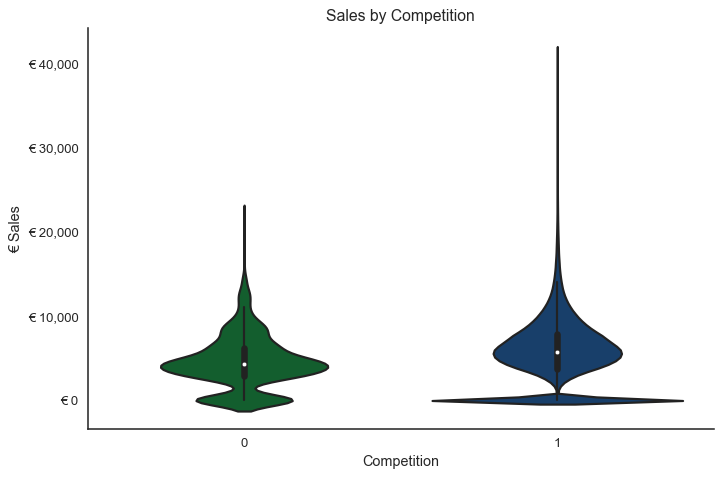

In [56]:
fig, ax = plt.subplots()

sns.violinplot(data = merged_data, 
               x = 'Ind_Competition', 
               y = 'Sales',
              palette = pal,
              ax = ax)

ax.set_title('Sales by Competition')
ax.set_xlabel('Competition')
ax.set_ylabel('€ Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])
sns.despine();

In [57]:
merged_data['Competition_Open_Date'] = \
pd.to_datetime(merged_data.CompetitionOpenSinceYear*10000+\
               merged_data.CompetitionOpenSinceMonth*100+\
               1,format='%Y%m%d')

merged_data['Competition_Age'] = (merged_data.index - merged_data.Competition_Open_Date)
merged_data['Competition_Age'] = merged_data.Competition_Age.dt.days

# def clean_comp_age(var):
#     if var < 0:
#         return(np.NaN)
#     else:
#         return(var)
    
# merged_data['Competition_Age'] = merged_data['Competition_Age'].apply(lambda x: clean_comp_age(x))
        
merged_data['Competition_Age'].describe() #ok with negative values as it can show pre-competiton launch

count    693861.000000
mean       1850.786619
std        2201.587805
min        -942.000000
25%         448.000000
50%        1558.000000
75%        2877.000000
max       42214.000000
Name: Competition_Age, dtype: float64

#### How does a new store (competition) impact sales?

In [58]:
def new_store(var): # assume a new store is one less than 6 months old (180  days)
    if (var >= -60) & (var <= 180): # grab 2 months of pre-launch data
        return(1)
    else:
        return(0)
        
        
merged_data['Ind_New_Competition'] = merged_data['Competition_Age'].apply(lambda x: new_store(x))

In [59]:
new_comp = merged_data[(merged_data['Ind_New_Competition'] == 1) & (merged_data['Open'] == 1)]

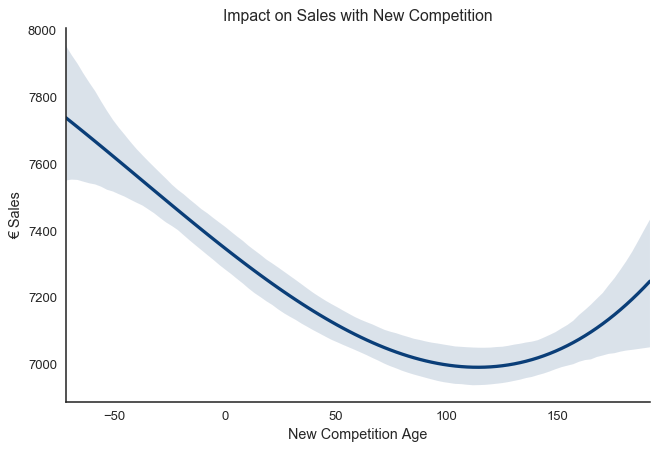

In [60]:
g = sns.lmplot(x = 'Competition_Age', 
              y = 'Sales',
              data = new_comp,
              order = 3,
              size = 5,
              aspect = 1.5,
               scatter = False,
              line_kws={'color': pal[1]})

plt.title('Impact on Sales with New Competition')
plt.xlabel('New Competition Age')
plt.ylabel('€ Sales');

In [61]:
new_comp['Days_Cut'] = pd.qcut(new_comp['Competition_Age'], 5)
new_comp.groupby('Days_Cut')['Sales'].median()

C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Days_Cut
(-60.001, -10.0]    6898.0
(-10.0, 40.0]       6610.5
(40.0, 90.0]        6243.0
(90.0, 137.0]       6415.5
(137.0, 180.0]      6408.0
Name: Sales, dtype: float64

#### Impact of Competition Distance

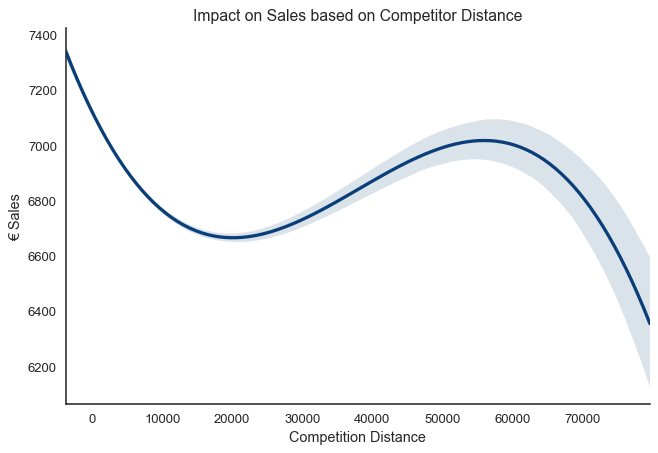

In [62]:
competitors = merged_data[(merged_data['Ind_Competition'] == 1) & (merged_data['Open'] == 1)]

g = sns.lmplot(x = 'CompetitionDistance', 
              y = 'Sales',
              data = competitors,
              order = 3,
              size = 5,
              aspect = 1.5,
               scatter = False,
              line_kws={'color': pal[1]})

plt.title('Impact on Sales based on Competitor Distance')
plt.xlabel('Competition Distance')
plt.ylabel('€ Sales');

In [63]:
competitors['Comp_Distance_Q'] = pd.qcut(competitors.CompetitionDistance, 4)
competitors['Comp_Age_Q'] = pd.qcut(competitors.Competition_Age, 4)

C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\ponle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


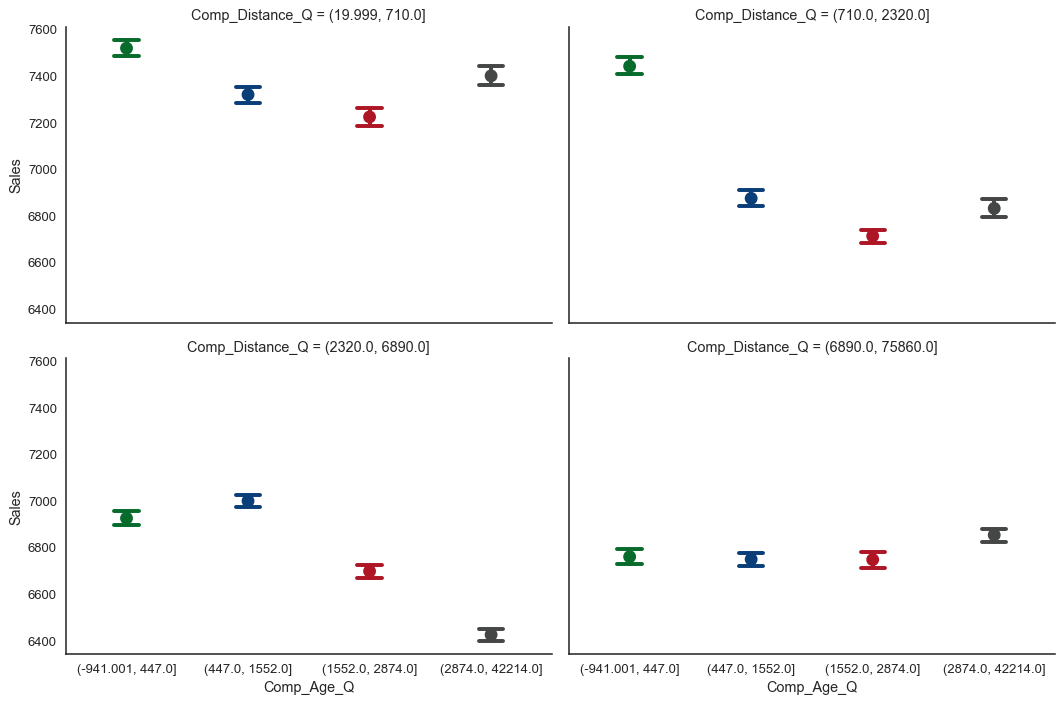

In [64]:
g = sns.factorplot(x="Comp_Age_Q", 
                   y="Sales", 
                   col="Comp_Distance_Q", 
                   col_wrap = 2,
                   data=competitors,
                   capsize=.2, 
                   palette=pal, 
                   size=4,
                  aspect = 1.5);

Competition Summary
* When a new competitor opens, we see a sizeable decrease in sales, which begins to rebound after about 100 days. (Does this impact all store types, promo stores in same way?)
* The impact of a competitor does depend upon the distance (in meters) along with the length of time the competitor has been in business.  

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
Store                 1017209 non-null int64
DayOfWeek             1017209 non-null int64
Sales                 1017209 non-null int64
Customers             1017209 non-null int64
Open                  1017209 non-null int64
Promo                 1017209 non-null int64
StateHoliday          1017209 non-null object
SchoolHoliday         1017209 non-null int64
Year                  1017209 non-null int64
Month                 1017209 non-null int64
Day                   1017209 non-null int64
WeekOfYear            1017209 non-null int64
Sales_Per_Customer    844340 non-null float64
dtypes: float64(1), int64(11), object(1)
memory usage: 128.6+ MB


In [66]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### Investigating the Store closure Dates - School Holidays, State Holidays, Weekends 


In [73]:

merged_data.head(20)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2_Start_Date,Days_Promo2_Participating,Ind_Competition,Competition_Open_Date,Competition_Age,Ind_New_Competition
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2524.0,0
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2523.0,0
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2522.0,0
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2521.0,0
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2520.0,0
2015-07-26,1,7,0,0,0,0,0,0,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2519.0,0
2015-07-25,1,6,4364,500,1,0,0,0,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2518.0,0
2015-07-24,1,5,3706,459,1,0,0,0,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2517.0,0
2015-07-23,1,4,3769,503,1,0,0,0,2015,7,...,0,NaN,NaN,NaN,NaT,NaN,1,2008-09-01,2516.0,0


In [145]:
#School Holiday dates
stores_observing_state_holidays = merged_data[(merged_data["StateHoliday"] != "0") & (merged_data["Open"]== 0) ]

In [160]:
#Determine state holidays
stores_observing_state_holidays.loc[0,"Date"] = pd.to_datetime(stores_observing_state_holidays.index)


TypeError: cannot insert DatetimeIndex with incompatible label